In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

In [5]:
import time
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
from scipy.special import jv

In [4]:
Z0=376.73
c0=3e8

In [5]:
eps1=1 #superstrate
eps2=1.7 #substrate
sig1=1j*8e-3
sig2=1j*4e-3
a0=5e-6
w=3e-6

#w=0.5*a0
theta=0
phi=0
M=100
lams=np.linspace(4,10,M)*1e-6
#print(lams)
sig_avg=sig1+(sig2-sig1)*(w/a0)
mu1=1
mu2=1

fd,fx,fy=w/a0,w/a0,w/a0
l0=a0/3**0.5

In [3]:
def JJ(z):
    z=z+1e-8
    return jv(1,z)/z

def ret_fresnel_coeff(S):
    a=len(S)//2
    M11=S[:a,:a]
    M12=S[:a,a:]
    M21=S[a:,:a]
    M22=S[a:,a:]
    M22_inv=np.linalg.inv(M22)
    B=np.zeros(np.shape(S),dtype=complex)
    B[:a,:a]=M11-M12@M22_inv@M21
    B[:a,a:]=M22_inv@M12
    B[a:,:a]=M22_inv
    B[a:,a:]=-M22_inv@M21
    return B

def plot_spectrum(TT,lam_list,kx_list,title,param='',save=False,cmap='afmhot'):
    f_list=c0/lam_list[::-1]
    N_lam=len(lam_list)
    N_kx=len(kx_list)
    fig, ax = plt.subplots(figsize=(16,7))
    cax = make_axes_locatable(ax).append_axes('right', size='5%', pad=0.05)        
    im1=ax.imshow(TT,origin='lower',cmap=cmap)
    ax.set_ylabel('$f(x10^{12}Hz)$',fontsize=22)
    ax.set_xlabel('$k_x/\\frac{\pi}{a_0}$',fontsize=22)
    #fig.colorbar(im1, cax=cax, orientation='vertical',label='$ln(det(T))$',labelsize=21)
    fig.colorbar(im1, cax=cax, orientation='vertical').set_label(label='$ln(det(T))$',size=22)

    MM=10
    ax.set_title(title,fontsize=22)
    ax.set_yticks(np.arange(0,N_lam,N_lam//MM))
    ax.set_yticklabels(np.round(f_list[::N_lam//MM]*1e-12,2))
    ax.set_xticks(np.arange(0,N_kx,N_kx//MM))
    ax.set_xticklabels(np.round(np.linspace(-1,1,MM+1),2))
    ax.grid(True,alpha=0.5,ls=':',lw=0.5,c='k')
    if save:plt.savefig('plots\{0}_{1}.png'.format(title,param), bbox_inches='tight')
    plt.show()
    
def reciprocal_lattice(N,theta,theta1=0):
    d_a=(2*np.pi/a0)*np.array([np.cos(theta1),np.sin(theta1)]).reshape(2,1)
    d_b=(2*np.pi/a0)*np.array([np.cos(theta),np.sin(theta)]).reshape(2,1)
    n_list=np.arange(-N,N+1)
    n_ab,n_ba=np.meshgrid(n_list,n_list)
    n_ab=n_ab.flatten()
    n_ba=n_ba.flatten()
    g_list=n_ab*d_a+n_ba*d_b
    return g_list.T

def moire_reciprocal(N,theta,alpha=0,gamma=1,delta=[0,0]):
    ap=gamma*a0
    delta=np.array(delta).reshape(2,1)
    d_a1=(2*np.pi/a0)*np.array([1,0]).reshape(2,1)
    d_a2=(2*np.pi/a0)*np.array([np.cos(theta),np.sin(theta)]).reshape(2,1)
    d_b1=(2*np.pi/ap)*np.array([np.cos(alpha),np.sin(alpha)]).reshape(2,1)
    d_b2=(2*np.pi/ap)*np.array([np.cos(theta+alpha),np.sin(theta+alpha)]).reshape(2,1)
    d_b1+=(2*np.pi/ap)*delta
    d_b2+=(2*np.pi/ap)*delta
    
    n1,n2=np.meshgrid(np.arange(-N[0],N[0]+1),np.arange(-N[1],N[1]+1))
    n11,n12=np.meshgrid(n1.flatten(),n1.flatten())
    n21,n22=np.meshgrid(n2.flatten(),n2.flatten())
#     na1,na2=np.meshgrid(np.arange(-N[0],N[0]+1),np.arange(-N[0],N[0]+1))
#     nb1,nb2=np.meshgrid(np.arange(-N[1],N[0]+1),np.arange(-N[1],N[1]+1))
#     n11,n12=np.meshgrid(na1,nb1)
#     n21,n22=np.meshgrid(na2,nb2)
    g_list=n11.flatten()*d_a1+n12.flatten()*d_a2+n21.flatten()*d_b1+n22.flatten()*d_b2
    return g_list.T

def S_translation(abs_kxy,k0,d,eps):
    if d==0:
        return np.eye(2*len(abs_kxy))
    else:
        kz=np.lib.scimath.sqrt(eps*k0**2-abs_kxy)
        S=np.diag(list(np.exp(1j*d*kz))+list(np.exp(-1j*d*kz)))
    return S

def Scatter_Mat(abs_kxy,k0,eps1,eps2,sig):
    M=len(abs_kxy)
    k1z=np.lib.scimath.sqrt(eps1*k0**2-abs_kxy)
    k2z=np.lib.scimath.sqrt(eps2*k0**2-abs_kxy)
    n_scat=np.diag((eps1/eps2)*(k2z/k1z))
    sig=(Z0/(eps2*k0))*(k2z+np.zeros((M,1)))*sig
    S=np.zeros((2*M,2*M),dtype=complex)
    S[:M,:M]=(np.eye(M)+n_scat+sig)/2
    S[M:,:M]=(np.eye(M)-n_scat-sig)/2
    S[:M,M:]=(np.eye(M)-n_scat+sig)/2
    S[M:,M:]=(np.eye(M)+n_scat-sig)/2
    return S

def transmission0(S):
    B=ret_fresnel_coeff(S)
    MM=np.shape(S)[0]//2
    I=np.zeros((2*MM,1))
    I[(MM-1)//2]=1
    fres=B@I
    T_0=np.sum(np.abs(fres))
    #T_0=np.sum((fres))
    #T_0=fres[(MM-1)//2]
    #R_0=fres[(MM-1)//2+MM]
    return T_0


In [7]:
def S_cond_2d_dispersion(kx_list,ky_list,lam,N,eps1,eps2,typ):
    k0=2*np.pi/lam
    TT=np.zeros((len(ky_list),len(kx_list)))
    g_list=reciprocal_lattice(N,np.pi/2+0,0)
    g_ab=g_list.reshape(1,(2*N+1)**2,2)/(2*np.pi/a0)
    nn21=(g_ab-np.transpose(g_ab,(1,0,2)))     
    M=np.shape(g_list)[0]
    if typ=='circle':
        sig=np.eye(M)*sig1+(sig2-sig1)*(np.pi*fd**2/2)*JJ(np.pi*fd*np.sum(nn21**2,axis=2)**0.5)      ## circular holes    ## RIGHT
    elif typ=='square':
        sig=np.eye(M)*sig1+(sig2-sig1)*(fx*fy)*np.sinc(fx*nn21[:,:,0])*np.sinc(fy*nn21[:,:,1])        ##square holes  ## in numpy sinc(x) is defined as sinc(pi*x)
    else : print('type not recognised')    

    for i_kx,kx in enumerate(kx_list):
        for i_ky,ky in enumerate(ky_list):
            kxy0=np.array([kx,ky]).reshape(1,2)
            abs_kxy=np.sum((kxy0+g_list)**2,axis=1)
            S=Scatter_Mat(abs_kxy,k0,eps1,eps2,sig)
            TT[i_ky][i_kx]=(np.abs(np.linalg.det(ret_fresnel_coeff(S))))

    return TT

def S_cond_sheet_2d(kx_list,lam_list,N,eps1,eps2,typ):
    k0_list=2*np.pi/lam_list
    TT=np.zeros((len(lam_list),len(kx_list)))
    g_list=reciprocal_lattice(N,np.pi/2)
    g_ab=g_list.reshape(1,(2*N+1)**2,2)/(2*np.pi/a0)
    nn21=(g_ab-np.transpose(g_ab,(1,0,2)))     
    M=np.shape(g_list)[0]
    if typ=='circle':
        sig=np.eye(M)*sig1+(sig2-sig1)*(np.pi*fd**2/2)*JJ(np.pi*fd*np.sum(nn21**2,axis=2)**0.5)     ## circular holes    ## RIGHT
    elif typ=='square':
        sig=np.eye(M)*sig1+(sig2-sig1)*(fx*fy)*np.sinc(fx*nn21[:,:,0])*np.sinc(fy*nn21[:,:,1])      ##square holes  ## in numpy sinc(x) is defined as sinc(pi*x)
    else : print('type not recognised')    

    for i_kx,kx in enumerate(kx_list):
        kxy0=np.array([kx,0]).reshape(1,2)
        abs_kxy=np.sum((kxy0+g_list)**2,axis=1)
        for i_k0,k0 in enumerate(k0_list):           
            S=Scatter_Mat(abs_kxy,k0,eps1,eps2,sig)
            TT[i_k0][i_kx]=(np.abs(np.linalg.det(ret_fresnel_coeff(S))))
    return TT

def S_cond_slab_2d(kx_list,lam_list,N,eps1,eps2,eps3,d,typ):
    k0_list=2*np.pi/lam_list
    TT=np.zeros((len(lam_list),len(kx_list)))
    g_list=reciprocal_lattice(N,np.pi/2)
    g_ab=g_list.reshape(1,(2*N+1)**2,2)/(2*np.pi/a0)
    nn21=(g_ab-np.transpose(g_ab,(1,0,2)))     
    M=np.shape(g_list)[0]
    
    if typ=='circle':
        sig=np.eye(M)*sig1+(sig2-sig1)*(np.pi*fd**2/2)*JJ(np.pi*fd*np.sum(nn21**2,axis=2)**0.5)      ## circular holes    ## RIGHT
    elif typ=='square':
        sig=np.eye(M)*sig1+(sig2-sig1)*(fx*fy)*np.sinc(fx*nn21[:,:,0])*np.sinc(fy*nn21[:,:,1])        ##square holes  ## in numpy sinc(x) is defined as sinc(pi*x)
    else : print('type not recognised')    
        
    for i_kx,kx in enumerate(kx_list):
        kxy0=np.array([kx,0]).reshape(1,2)
        abs_kxy=np.sum((kxy0+g_list)**2,axis=1)
        for i_k0,k0 in enumerate(k0_list):           
            S=Scatter_Mat(abs_kxy,k0,eps2,eps3,sig)@S_translation(abs_kxy,k0,d,eps2)@Scatter_Mat(abs_kxy,k0,eps1,eps2,sig)
            TT[i_k0][i_kx]=(np.abs(np.linalg.det(ret_fresnel_coeff(S))))
    return TT


In [8]:
def S_cond_slab_1d(kx_list,lam_list,N,eps1,eps2,eps3,d):
    TT=np.zeros((len(lam_list),len(kx_list)))
    k0_list=2*np.pi/lam_list
    n_list=np.arange(-N,N+1)
    g_list=(2*np.pi/a0)*n_list
    g21=n_list.reshape(1,len(n_list))
    g21=(2*np.pi/a0)*(g21-g21.T)
    M=np.shape(g_list)[0]
    sig=(np.eye(M)*sig1+(sig2-sig1)*(w/a0)*np.sinc((w/(2*np.pi))*g21))
    
    for i_kx,kx in enumerate(kx_list):
        abs_kxy=(kx+g_list)**2
        for i_k0,k0 in enumerate(k0_list):
            S=Scatter_Mat(abs_kxy,k0,eps2,eps3,sig)@S_translation(abs_kxy,k0,d,eps2)@Scatter_Mat(abs_kxy,k0,eps1,eps2,sig)
            TT[i_k0][i_kx]=(np.abs(np.linalg.det(ret_fresnel_coeff(S))))
    return TT

def S_cond_sheet_1d(kx_list,lam_list,N,eps1,eps2):
    TT=np.zeros((len(lam_list),len(kx_list)))
    k0_list=2*np.pi/lam_list
    n_list=np.arange(-N,N+1)
    g_list=(2*np.pi/a0)*n_list
    g21=n_list.reshape(1,len(n_list))
    g21=(2*np.pi/a0)*(g21-g21.T)
    M=np.shape(g_list)[0]
    sig=(np.eye(M)*sig1+(sig2-sig1)*(w/a0)*np.sinc((w/(2*np.pi))*g21))
    
    for i_kx,kx in enumerate(kx_list):
        abs_kxy=(kx+g_list)**2
        for i_k0,k0 in enumerate(k0_list):
            S=Scatter_Mat(abs_kxy,k0,eps1,eps2,sig)
            TT[i_k0][i_kx]=(np.abs(np.linalg.det(ret_fresnel_coeff(S))))
    return TT

def S_cond_1d_dispersion(kx_list,ky_list,lam,N,eps1,eps2):
    TT=np.zeros((len(ky_list),len(kx_list)))
    k0=2*np.pi/lam
    n_list=np.arange(-N,N+1)
    g_list=(2*np.pi/a0)*n_list
    g21=n_list.reshape(1,len(n_list))
    g21=(2*np.pi/a0)*(g21-g21.T)
    M=np.shape(g_list)[0]
    sig=(np.eye(M)*sig1+(sig2-sig1)*(w/a0)*np.sinc((w/(2*np.pi))*g21))
    
    for i_kx,kx in enumerate(kx_list):
        for i_ky,ky in enumerate(ky_list):
            abs_kxy=(kx+g_list)**2+ky**2
            S=Scatter_Mat(abs_kxy,k0,eps1,eps2,sig)
            TT[i_ky][i_kx]=(np.abs(np.linalg.det(ret_fresnel_coeff(S))))
    return TT

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide


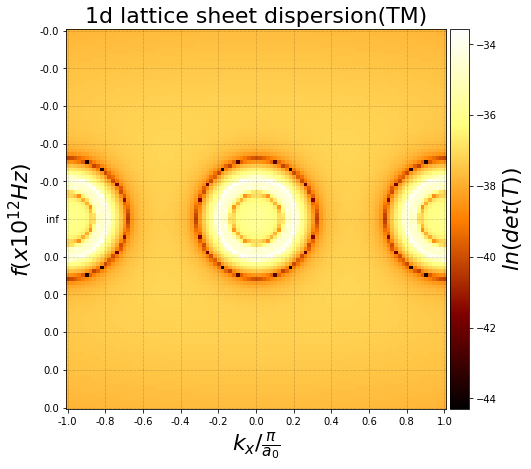

7.4375


In [27]:
N=5
lam=3e-5
N_kx=101
N_ky=N_kx
kx_list=2*(np.pi/a0)*np.linspace(-1,1,N_kx)
ky_list=2*(np.pi/a0)*np.linspace(-1,1,N_ky)
start=time.process_time()
TT=S_cond_1d_dispersion(kx_list,ky_list,lam,N,eps1,eps2)
plot_spectrum(np.log(TT),ky_list,kx_list,'1d lattice sheet dispersion(TM)','_N='+str(N),save=False)
print(time.process_time()-start)

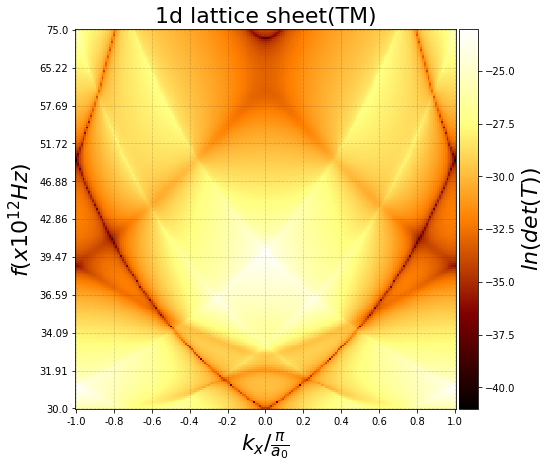

18.03125


In [154]:
N=5
N_kx=201
N_lam=N_kx
kx_list=(np.pi/a0)*np.linspace(-1,1,N_kx)
lam_list=np.linspace(4,10,N_lam)*1e-6
start=time.process_time()
TT=S_cond_sheet_1d(kx_list,lam_list,N,eps1,eps2)
plot_spectrum(np.log(TT),lam_list,kx_list,'1d lattice sheet(TM)','_N='+str(N),save=False)
print(time.process_time()-start)

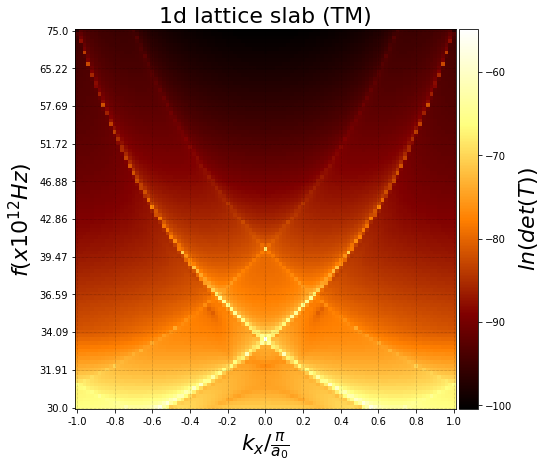

67.421875


In [150]:
d=1e-1*a0
N=5
N_kx=101
N_lam=N_kx
kx_list=(np.pi/a0)*np.linspace(-1,1,N_kx)
lam_list=np.linspace(4,10,N_lam)*1e-6
start=time.process_time()
TT=S_cond_slab_1d(kx_list,lam_list,N,eps1,eps2,eps1,d)
plot_spectrum(np.log(TT),lam_list,kx_list,'1d lattice slab (TM)','_N='+str(N),save=False)
print(time.process_time()-start)

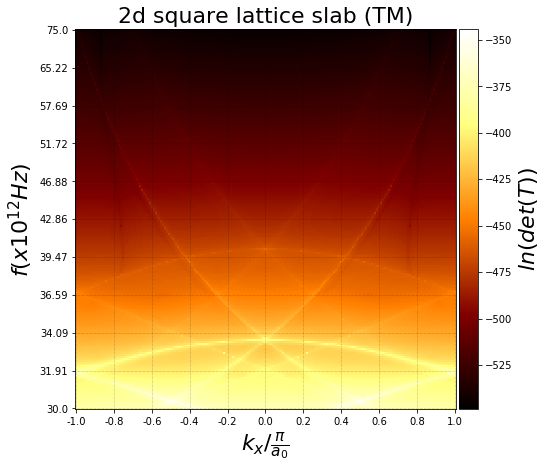

2888.546875


In [29]:
d=1e-1*a0
N=3
N_kx=201
N_lam=N_kx
kx_list=np.linspace(-1,1,N_kx)*np.pi/a0
lam_list=np.linspace(4,10,N_lam)*1e-6
start=time.process_time()
TT=S_cond_slab_2d(kx_list,lam_list,N,eps1,eps2,eps1,d,'circle')
plot_spectrum(np.log(TT),lam_list,kx_list,'2d square lattice slab (TM)','_N='+str(N),save=False)
print(time.process_time()-start)

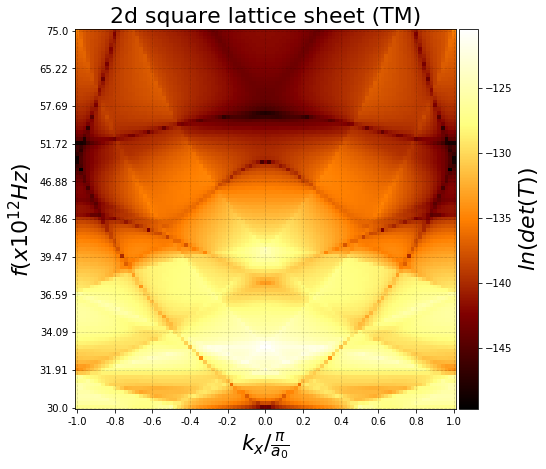

361.296875


In [32]:
N=3
N_kx=101
N_lam=N_kx
kx_list=np.linspace(-1,1,N_kx)*np.pi/a0
lam_list=np.linspace(4,10,N_lam)*1e-6
start=time.process_time()
TT=S_cond_sheet_2d(kx_list,lam_list,N,eps1,eps2,'circle')
plot_spectrum(np.log(TT),lam_list,kx_list,'2d square lattice sheet (TM)','_N='+str(N),save=True)
print(time.process_time()-start)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide


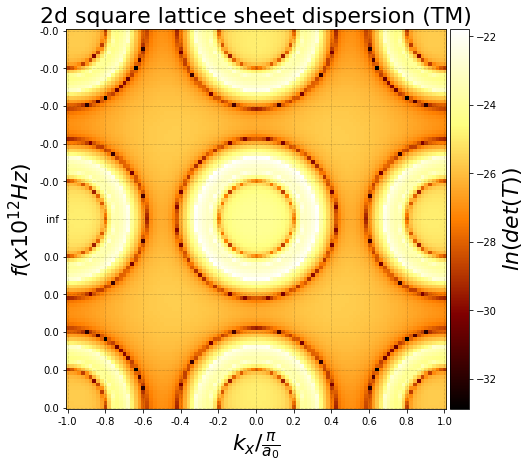

7.5


In [66]:
N=1
N_kx=101
N_ky=N_kx
kx_list=2*np.linspace(-1,1,N_kx)*np.pi/a0
ky_list=2*np.linspace(-1,1,N_ky)*np.pi/a0
lam=2e-5
start=time.process_time()
TT=S_cond_2d_dispersion(kx_list,ky_list,lam,N,eps1,eps2,'circle')
plot_spectrum(np.log(TT),ky_list,kx_list,'2d square lattice sheet dispersion (TM)','_N='+str(N),save=False)
print(time.process_time()-start)

In [183]:
def S_sheet_graphene(kx_list,ky_list,lam_list,N,eps1,eps2):
    TT=np.zeros((len(lam_list),len(kx_list)))
    k0_list=2*np.pi/lam_list

    g_list=reciprocal_lattice(N,0,np.pi/3)
    M=np.shape(g_list)[0]
    g_ab=g_list.reshape(1,M,2)
    g_ab=(g_ab-np.transpose(g_ab,(1,0,2))) 
    sig=np.eye(M)*sig1+(sig2-sig1)*(np.pi*fd**2/2)*JJ((w/2)*np.sum(g_ab**2,axis=2)**0.5)*2*np.cos(g_ab[:,:,1]*l0/2)
    
    for p in range(len(kx_list)):
        kxy0=np.array([kx_list[p],ky_list[p]]).reshape(1,2)
        abs_kxy=np.sum((kxy0+g_list)**2,axis=1)
        for i_k0,k0 in enumerate(k0_list):
            S=Scatter_Mat(abs_kxy,k0,N,eps1,eps2,sig)
            TT[i_k0][p]=(np.abs(np.linalg.det(ret_fresnel_coeff(S))))
    return TT

def S_slab_graphene(kx_list,ky_list,lam_list,N,eps1,eps2,d):
    TT=np.zeros((len(lam_list),len(kx_list)))
    k0_list=2*np.pi/lam_list
#     d_a=(2/3**0.5)*(2*np.pi/a0)*np.array([np.cos(-np.pi/6),np.sin(-np.pi/6)]).reshape(2,1)
#     d_b=(2/3**0.5)*(2*np.pi/a0)*np.array([np.cos(np.pi/6),np.sin(np.pi/6)]).reshape(2,1)
#     n_list=np.arange(-N,N+1)
#     nx=[]
#     ny=[]
#     for n_i in n_list:
#         for n_j in n_list:
#             if np.abs(n_i+n_j)<=N:
#                 nx.append(n_i)
#                 ny.append(n_j)
#     n_ab=np.array(nx)       
#     n_ba=np.array(ny)  
#     g_list=n_ab*d_a+n_ba*d_b

    g_list=reciprocal_lattice(N,0,np.pi/3)
    M=np.shape(g_list)[0]
    
    g_ab=g_list.reshape(1,(2*N+1)**2,2)
    g_ab=(g_ab-np.transpose(g_ab,(1,0,2))) 
    
    sig=np.eye(M)*sig1+(sig2-sig1)*(np.pi*fd**2/2)*JJ((w/2)*np.sum(g_ab**2,axis=2)**0.5)*2*np.cos(g_ab[:,:,1]*l0/2)
    
    for p in range(len(kx_list)):
        kxy0=np.array([kx_list[p],ky_list[p]]).reshape(1,2)
        abs_kxy=np.sum((kxy0+g_list)**2,axis=1)
        for i_k0,k0 in enumerate(k0_list):
            S=Scatter_Mat(abs_kxy,k0,eps1,eps2,sig)@S_translation(abs_kxy,k0,d,eps2)@Scatter_Mat(abs_kxy,k0,eps2,eps1,sig)
            TT[i_k0][p]=(np.abs(np.linalg.det(ret_fresnel_coeff(S))))
    return TT

(25, 2)


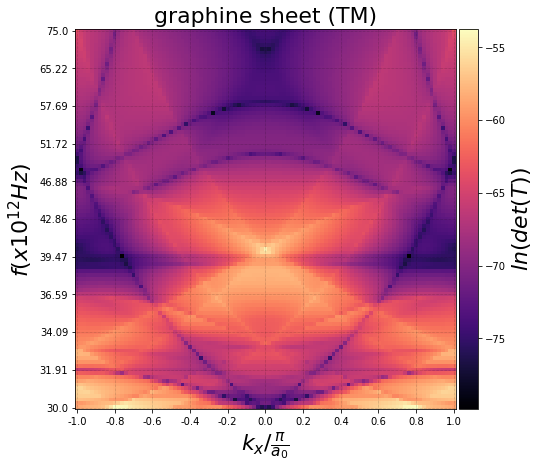

64.921875


In [129]:
N=2
N_kx=101
N_lam=N_kx
kx_list=np.linspace(-1,1,N_kx)*(np.pi/a0)
ky_list=0*np.linspace(-1,1,N_kx)*(np.pi/a0)
#print(ky_list)
lam_list=np.linspace(4,10,N_lam)*1e-6
start=time.process_time()
TT=S_sheet_graphene(kx_list,ky_list,lam_list,N,eps1,eps2)
plot_spectrum(np.log(TT),lam_list,kx_list,'graphine sheet (TM)','N='+str(N),False,'magma')
print(time.process_time()-start)

In [154]:
def S_moire_1d_dispersion(kx_list,ky_list,lam,N,eps1,eps2,alpha=0):
    k0=2*np.pi/lam
    gamma=1
    delta=0
    a1=gamma*a0
    d=9e-1*a0
    h=0    
    g_list=reciprocal_lattice(N,-alpha/2,alpha/2)
    gg=np.arange(-N,N+1).reshape(1,2*N+1)
    gg=(2*np.pi/a0)*(gg-gg.T)
    
    sig_a=np.eye(2*N+1)*sig1+(sig2-sig1)*(w/a0)*np.sinc((w/(2*np.pi))*gg)
    sig_a=np.kron(np.eye(2*N+1),sig_a)
    sig_b=np.eye(2*N+1)*sig1+(sig2-sig1)*(w/a0)*np.sinc((w/(2*np.pi))*gg)*np.exp(1j*gg*delta*a0)
    sig_b=np.kron(sig_b,np.eye(2*N+1))

    TT=np.zeros((len(ky_list),len(kx_list)))
    for i_kx,kx in enumerate(kx_list):
        for i_ky,ky in enumerate(ky_list):
            kxy0=np.array([kx,ky]).reshape(1,2)
            abs_kxy=np.sum((kxy0+g_list)**2,axis=1)

#             Slab_a=S_moire(eps2,eps3,abs_kxy,sig_a,k0)@S_translate(eps2,abs_kxy,d,k0)@S_moire(eps1,eps2,abs_kxy,sig_a,k0)
#             Slab_b=S_moire(eps4,eps5,abs_kxy,sig_b,k0)@S_translate(eps4,abs_kxy,d,k0)@S_moire(eps3,eps4,abs_kxy,sig_b,k0)
#             S=Slab_b@S_translate(eps3,abs_kxy,h,k0)@Slab_a
            S=Scatter_Mat(abs_kxy,k0,eps2,eps1,sig_b)@S_translation(abs_kxy,k0,d,eps2)@Scatter_Mat(abs_kxy,k0,eps1,eps2,sig_a)
            #TT[i_ky][i_kx]=(np.abs(np.linalg.det(ret_fresnel_coeff(S))))
            TT[i_ky][i_kx]=(np.abs(transmission0(S)))
    return TT

def S_moire_1d(lam_list,kx_list,N,eps1,eps2,alpha=0):
    k0_list=2*np.pi/lam_list
    gamma=1
    delta=0.5
    a1=gamma*a0
    d=1e-1*a0
    h=0    
    g_list=reciprocal_lattice(N,alpha)
    gg=np.arange(-N,N+1).reshape(1,2*N+1)
    gg=(2*np.pi/a0)*(gg-gg.T)
    
    sig_a=np.eye(2*N+1)*sig1+(sig2-sig1)*(w/a0)*np.sinc((w/(2*np.pi))*gg)
    sig_a=np.kron(np.eye(2*N+1),sig_a)
    sig_b=np.eye(2*N+1)*sig1+(sig2-sig1)*(w/a0)*np.sinc((w/(2*np.pi))*gg)*np.exp(1j*gg*(2*delta-1)*w/4)
    sig_b=np.kron(sig_b,np.eye(2*N+1))
    
    TT=np.zeros((len(lam_list),len(kx_list)))
    for i_kx,kx in enumerate(kx_list):
        kxy0=np.array([kx,0]).reshape(1,2)
        abs_kxy=np.sum((kxy0+g_list)**2,axis=1)
        for i_k0,k0 in enumerate(k0_list):
#             Slab_a=S_moire(eps2,eps3,abs_kxy,sig_a,k0)@S_translate(eps2,abs_kxy,d,k0)@S_moire(eps1,eps2,abs_kxy,sig_a,k0)
#             Slab_b=S_moire(eps4,eps5,abs_kxy,sig_b,k0)@S_translate(eps4,abs_kxy,d,k0)@S_moire(eps3,eps4,abs_kxy,sig_b,k0)
#             S=Slab_b@S_translate(eps3,abs_kxy,h,k0)@Slab_a
            S=Scatter_Mat(abs_kxy,k0,eps2,eps1,sig_b)@S_translation(abs_kxy,k0,d,eps2)@Scatter_Mat(abs_kxy,k0,eps1,eps2,sig_a)
            TT[i_k0][i_kx]=(np.abs(np.linalg.det(ret_fresnel_coeff(S))))
    return TT

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide


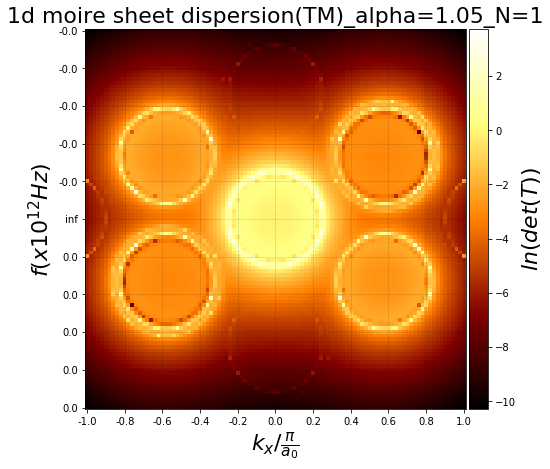

10.4375


In [155]:
alpha=np.pi/3
#alpha=0.1
N=1
N_kx=101
N_ky=N_kx
kx_list=3*np.linspace(-1,1,N_kx)*np.pi/a0
ky_list=3*np.linspace(-1,1,N_ky)*np.pi/a0
lam=1e-5*1.5
start=time.process_time()
TT=S_moire_1d_dispersion(kx_list,ky_list,lam,N,eps1,eps2,alpha)
plot_spectrum(np.log(TT),ky_list,kx_list,'1d moire sheet dispersion(TM)_alpha='+str(np.round(alpha,2))+'_N='+str(N),save=False)
print(time.process_time()-start)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide


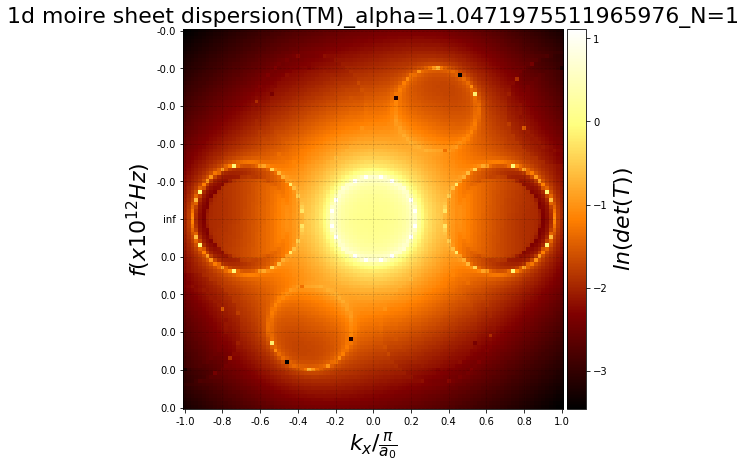

9.875


In [89]:
alpha=np.pi/3
#alpha=0.1
N=1
N_kx=101
N_ky=N_kx
kx_list=3*np.linspace(-1,1,N_kx)*np.pi/a0
ky_list=3*np.linspace(-1,1,N_ky)*np.pi/a0
lam=1e-5*1.5
start=time.process_time()
TT=S_moire_1d_dispersion(kx_list,ky_list,lam,N,eps1,eps2,alpha)
plot_spectrum(np.log(TT),ky_list,kx_list,'1d moire sheet dispersion(TM)_alpha='+str(np.round(alpha,2))+'_N='+str(N),save=False)
print(time.process_time()-start)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide


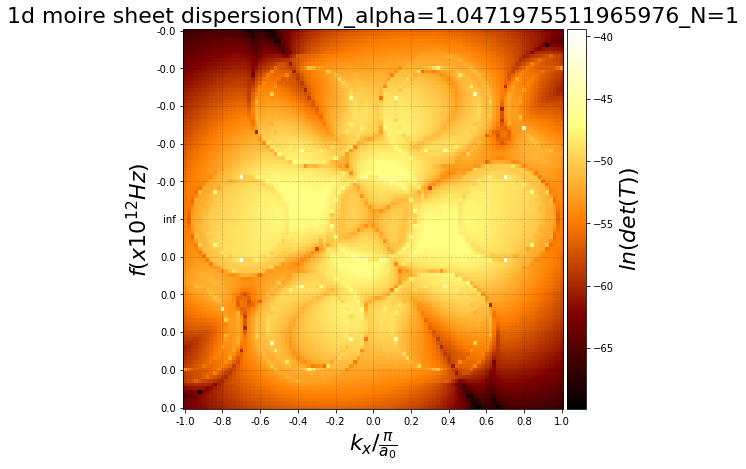

10.40625


In [79]:
alpha=np.pi/3
#alpha=0.1
N=1
N_kx=101
N_ky=N_kx
kx_list=3*np.linspace(-1,1,N_kx)*np.pi/a0
ky_list=3*np.linspace(-1,1,N_ky)*np.pi/a0
lam=1e-5*1.5
start=time.process_time()
TT=S_moire_1d_dispersion(kx_list,ky_list,lam,N,eps1,eps2,alpha)
plot_spectrum(np.log(TT),ky_list,kx_list,'1d moire sheet dispersion(TM)_alpha='+str(alpha)+'_N='+str(N),save=False)
print(time.process_time()-start)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide


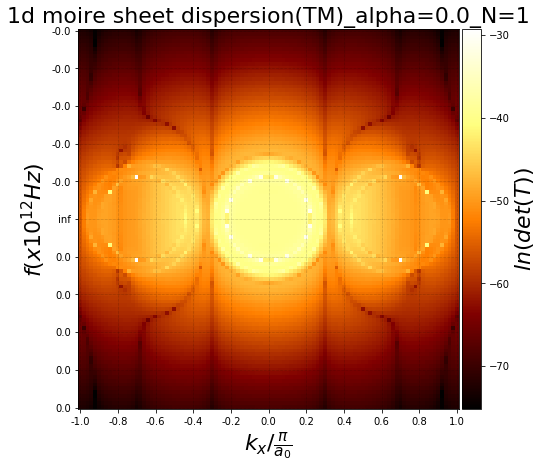

10.265625


In [80]:
#alpha=np.pi/6
alpha=0.0
N=1
N_kx=101
N_ky=N_kx
kx_list=3*np.linspace(-1,1,N_kx)*np.pi/a0
ky_list=3*np.linspace(-1,1,N_ky)*np.pi/a0
lam=1e-5*1.5
start=time.process_time()
TT=S_moire_1d_dispersion(kx_list,ky_list,lam,N,eps1,eps2,alpha)
plot_spectrum(np.log(TT),ky_list,kx_list,'1d moire sheet dispersion(TM)_alpha='+str(alpha)+'_N='+str(N),save=False)
print(time.process_time()-start)

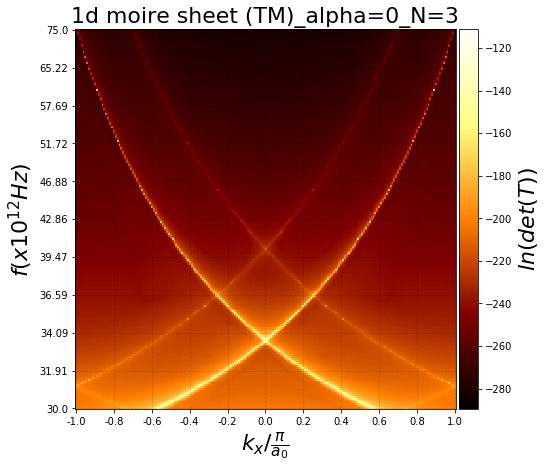

1013.8125


In [103]:
#alpha=np.pi/6
alpha=0
N=3
N_kx=201
N_lam=N_kx
kx_list=np.linspace(-1,1,N_kx)*np.pi/a0
lam_list=np.linspace(4,10,N_lam)*1e-6
start=time.process_time()
TT=S_moire_1d(lam_list,kx_list,N,eps1,eps2,alpha)
plot_spectrum(np.log(TT),lam_list,kx_list,'1d moire sheet (TM)_alpha='+str(alpha)+'_N='+str(N),save=True)
print(time.process_time()-start)

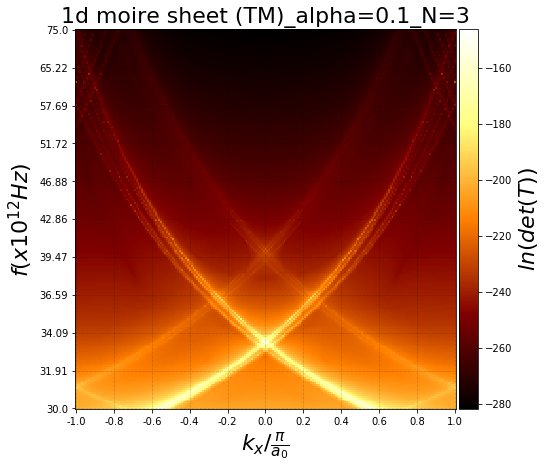

1091.53125


In [104]:
#alpha=np.pi/6
alpha=0.1
N=3
N_kx=201
N_lam=N_kx
kx_list=np.linspace(-1,1,N_kx)*np.pi/a0
lam_list=np.linspace(4,10,N_lam)*1e-6
start=time.process_time()
TT=S_moire_1d(lam_list,kx_list,N,eps1,eps2,alpha)
plot_spectrum(np.log(TT),lam_list,kx_list,'1d moire sheet (TM)_alpha='+str(alpha)+'_N='+str(N),save=True)
print(time.process_time()-start)

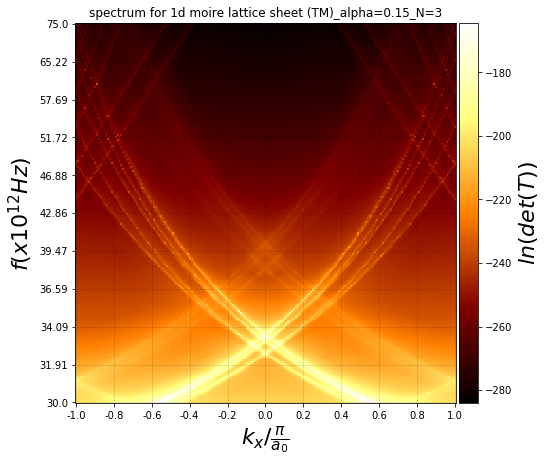

1030.390625


In [56]:
alpha=0.15
N=3
N_kx=201
N_lam=N_kx
kx_list=np.linspace(-1,1,N_kx)*np.pi/a0
lam_list=np.linspace(4,10,N_lam)*1e-6
start=time.process_time()
TT=S_moire_1d(lam_list,kx_list,N,eps1,eps2,alpha)
plot_spectrum(np.log(TT),lam_list,kx_list,'1d moire sheet (TM)_alpha='+str(alpha)+'_N='+str(N),save=True)
print(time.process_time()-start)

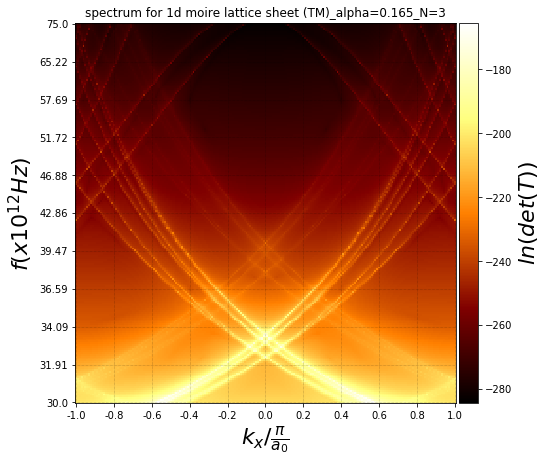

1005.4375


In [57]:
#alpha=np.pi/6
alpha=0.165
N=3
N_kx=201
N_lam=N_kx
kx_list=np.linspace(-1,1,N_kx)*np.pi/a0
lam_list=np.linspace(4,10,N_lam)*1e-6
start=time.process_time()
TT=S_moire_1d(lam_list,kx_list,N,eps1,eps2,alpha)
plot_spectrum(np.log(TT),lam_list,kx_list,'1d moire sheet (TM)_alpha='+str(alpha)+'_N='+str(N),save=True)
print(time.process_time()-start)

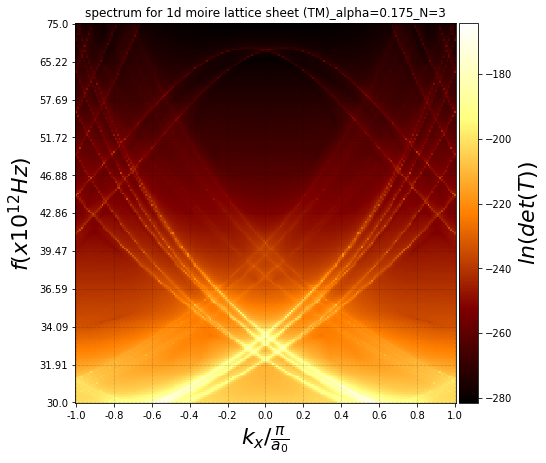

1002.84375


In [58]:
#alpha=np.pi/6
alpha=0.175
N=3
N_kx=201
N_lam=N_kx
kx_list=np.linspace(-1,1,N_kx)*np.pi/a0
lam_list=np.linspace(4,10,N_lam)*1e-6
start=time.process_time()
TT=S_moire_1d(lam_list,kx_list,N,eps1,eps2,alpha)
plot_spectrum(np.log(TT),lam_list,kx_list,'1d moire sheet (TM)_alpha='+str(alpha)+'_N='+str(N),save=True)
print(time.process_time()-start)

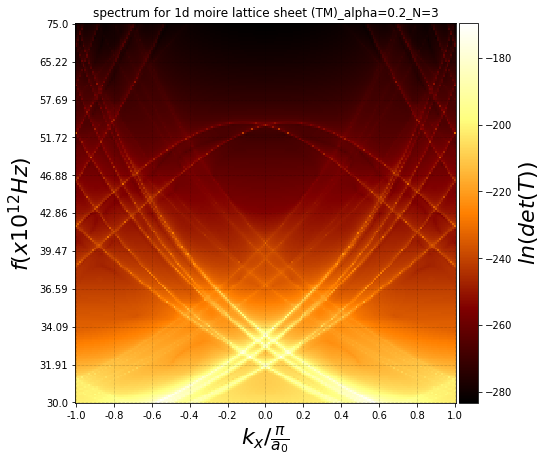

1006.203125


In [59]:
#alpha=np.pi/6
alpha=0.2
N=3
N_kx=201
N_lam=N_kx
kx_list=np.linspace(-1,1,N_kx)*np.pi/a0
lam_list=np.linspace(4,10,N_lam)*1e-6
start=time.process_time()
TT=S_moire_1d(lam_list,kx_list,N,eps1,eps2,alpha)
plot_spectrum(np.log(TT),lam_list,kx_list,'1d moire sheet (TM)_alpha='+str(alpha)+'_N='+str(N),save=True)
print(time.process_time()-start)

(2, 6561)


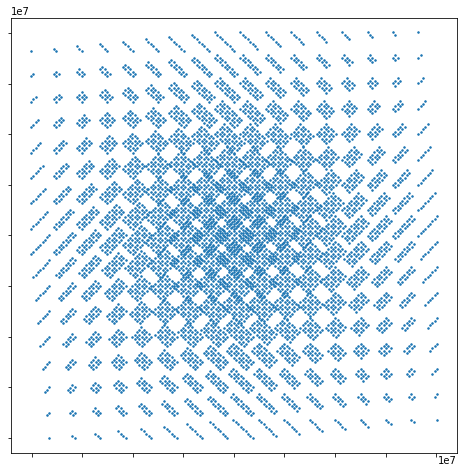

In [18]:
N=4
alpha=0.1
g_list=moire_reciprocal([N,N],np.pi/2,alpha,1.1).T
print(np.shape(g_list))
plt.figure(figsize=(8,8))
plt.plot(g_list[0,:],g_list[1,:],'.',markersize=3)
plt.tick_params(labelbottom=False,labelleft=False)
plt.axis('equal')
#plt.savefig('plots\moire_2d_alpha='+str(np.round(alpha,3))+'.jpg')
plt.show()

In [12]:
def S_moire_2d_dispersion(kx_list,ky_list,lam,N,eps1,eps2,alpha=0):
    k0=2*np.pi/lam
    M=(2*N+1)**2
    gamma=1
    delta=0.5
    a1=gamma*a0
    d=2e-1*a0
    h=0
       
    gg=reciprocal_lattice(N,np.pi/2).reshape(1,M,2)
    gg=(gg-np.transpose(gg,(1,0,2)))
    g_list=moire_reciprocal([N,N],np.pi/2,alpha)
    
    sig_a=np.eye(M)*sig1+(sig2-sig1)*(np.pi*fd**2/2)*JJ((w/2)*np.sum(gg**2,axis=2)**0.5)
    sig_a=np.kron(np.eye(M),sig_a)
    sig_b=np.eye(M)*sig1+(sig2-sig1)*(np.pi*fd**2/2)*JJ((w/2)*np.sum(gg**2,axis=2)**0.5)*np.exp(1j*np.sum(gg**2,axis=2)**0.5*(2*delta-1)*w/4)
    sig_b=np.kron(sig_b,np.eye(M))
    
    TT=np.zeros((len(ky_list),len(kx_list)))
    for i_kx,kx in enumerate(kx_list):
        for i_ky,ky in enumerate(ky_list):
            kxy0=np.array([kx,ky]).reshape(1,2)
            abs_kxy=np.sum((kxy0+g_list)**2,axis=1)
        
#             Slab_a=S_moire(eps2,eps3,abs_kxy,sig_a,k0)@S_translate(eps2,abs_kxy,d,k0)@S_moire(eps1,eps2,abs_kxy,sig_a,k0)
#             Slab_b=S_moire(eps4,eps5,abs_kxy,sig_b,k0)@S_translate(eps4,abs_kxy,d,k0)@S_moire(eps3,eps4,abs_kxy,sig_b,k0)
#             S=Slab_b@S_translate(eps3,abs_kxy,h,k0)@Slab_a
            S=Scatter_Mat(abs_kxy,k0,eps2,eps1,sig_b)@S_translation(abs_kxy,k0,d,eps2)@Scatter_Mat(abs_kxy,k0,eps1,eps2,sig_a)
            TT[i_ky][i_kx]=(np.abs(np.linalg.det(ret_fresnel_coeff(S))))
            #TT[i_ky][i_kx]=(np.abs(transmission0(S)))
    return TT

def S_moire_2d(lam_list,kx_list,N,eps1,eps2,alpha=0):
    k0_list=2*np.pi/lam_list
    M=(2*N+1)**2
    gamma=1
    delta=0.5
    a1=gamma*a0
    d=1e-1*a0
    h=0
       
    gg=reciprocal_lattice(N,np.pi/2).reshape(1,M,2)
    gg=(gg-np.transpose(gg,(1,0,2)))
    g_list=moire_reciprocal(N,np.pi/2,alpha)
    
    sig_a=np.eye(M)*sig1+(sig2-sig1)*(np.pi*fd**2/2)*JJ((w/2)*np.sum(gg**2,axis=2)**0.5)
    sig_a=np.kron(np.eye(M),sig_a)
    sig_b=np.eye(M)*sig1+(sig2-sig1)*(np.pi*fd**2/2)*JJ((w/2)*np.sum(gg**2,axis=2)**0.5)*np.exp(1j*np.sum(gg**2,axis=2)**0.5*(2*delta-1)*w/4)
    sig_b=np.kron(sig_b,np.eye(M))
    
    TT=np.zeros((len(lam_list),len(kx_list)))
    for i_kx,kx in enumerate(kx_list):
        kxy0=np.array([kx,0]).reshape(1,2)
        abs_kxy=np.sum((kxy0+g_list)**2,axis=1)
        for i_k0,k0 in enumerate(k0_list):
#             Slab_a=S_moire(eps2,eps3,abs_kxy,sig_a,k0)@S_translate(eps2,abs_kxy,d,k0)@S_moire(eps1,eps2,abs_kxy,sig_a,k0)
#             Slab_b=S_moire(eps4,eps5,abs_kxy,sig_b,k0)@S_translate(eps4,abs_kxy,d,k0)@S_moire(eps3,eps4,abs_kxy,sig_b,k0)
#             S=Slab_b@S_translate(eps3,abs_kxy,h,k0)@Slab_a
            S=Scatter_Mat(abs_kxy,k0,eps2,eps1,sig_b)@S_translation(abs_kxy,k0,d,eps2)@Scatter_Mat(abs_kxy,k0,eps1,eps2,sig_a)
            TT[i_k0][i_kx]=(np.abs(np.linalg.det(ret_fresnel_coeff(S))))
    return TT

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide


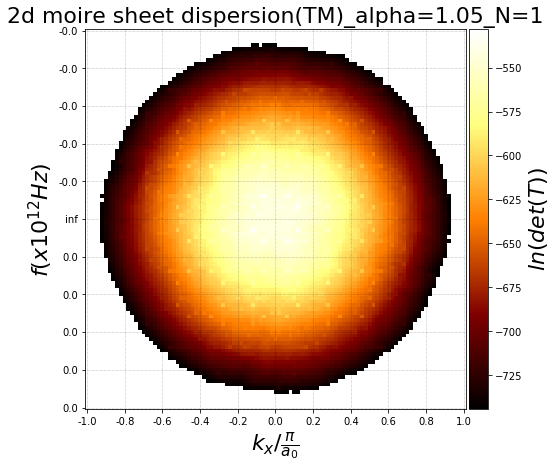

523.296875


In [13]:
alpha=np.pi/3
N=1          ## dont put more than 1
N_kx=101
N_ky=N_kx
kx_list=5*np.linspace(-1,1,N_kx)*np.pi/a0
ky_list=5*np.linspace(-1,1,N_ky)*np.pi/a0
lam=1e-5*1.5
start=time.process_time()
TT=S_moire_2d_dispersion(kx_list,ky_list,lam,N,eps1,eps2,alpha)
plot_spectrum(np.log(TT),ky_list,kx_list,'2d moire sheet dispersion(TM)_alpha='+str(np.round(alpha,2))+'_N='+str(N),save=False)
print(time.process_time()-start)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide


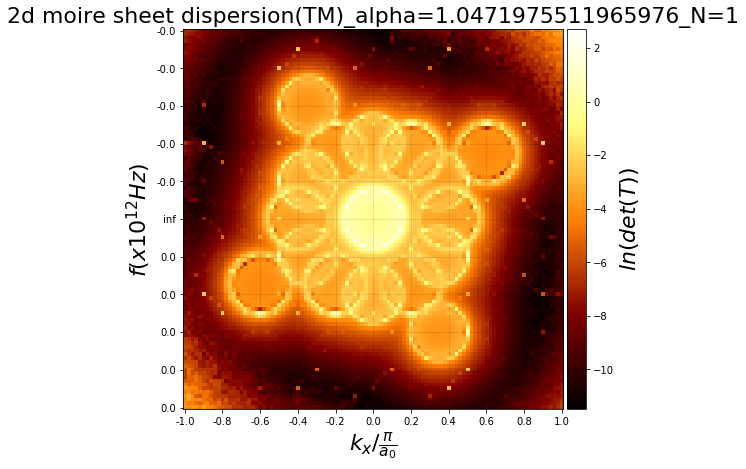

478.71875


In [159]:
alpha=np.pi/3
N=1          ## dont put more than 1
N_kx=101
N_ky=N_kx
kx_list=5*np.linspace(-1,1,N_kx)*np.pi/a0
ky_list=5*np.linspace(-1,1,N_ky)*np.pi/a0
lam=1e-5*1.5
start=time.process_time()
TT=S_moire_2d_dispersion(kx_list,ky_list,lam,N,eps1,eps2,alpha)
plot_spectrum(np.log(TT),ky_list,kx_list,'2d moire sheet dispersion(TM)_alpha='+str(np.round(alpha,2))+'_N='+str(N),save=False)
print(time.process_time()-start)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide


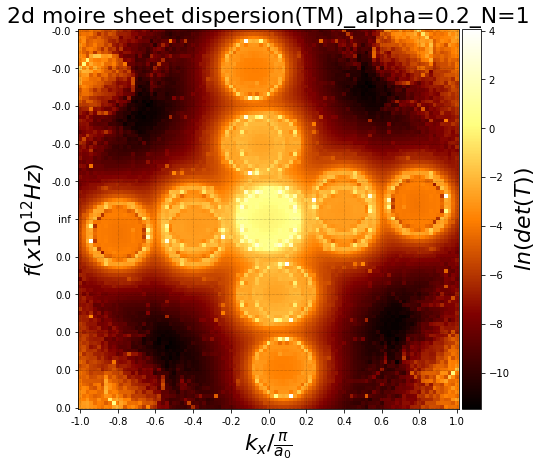

493.109375


In [158]:
alpha=0.2
N=1          ## dont put more than 1
N_kx=101
N_ky=N_kx
kx_list=5*np.linspace(-1,1,N_kx)*np.pi/a0
ky_list=5*np.linspace(-1,1,N_ky)*np.pi/a0
lam=1e-5*1.5
start=time.process_time()
TT=S_moire_2d_dispersion(kx_list,ky_list,lam,N,eps1,eps2,alpha)
plot_spectrum(np.log(TT),ky_list,kx_list,'2d moire sheet dispersion(TM)_alpha='+str(np.round(alpha,2))+'_N='+str(N),save=False)
print(time.process_time()-start)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide


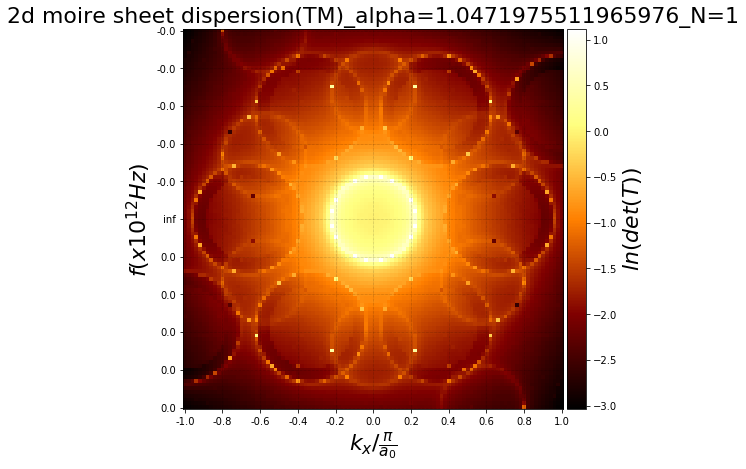

471.609375


In [91]:
alpha=np.pi/3
N=1          ## dont put more than 1
N_kx=101
N_ky=N_kx
kx_list=3*np.linspace(-1,1,N_kx)*np.pi/a0
ky_list=3*np.linspace(-1,1,N_ky)*np.pi/a0
lam=1e-5*1.5
start=time.process_time()
TT=S_moire_2d_dispersion(kx_list,ky_list,lam,N,eps1,eps2,alpha)
plot_spectrum(np.log(TT),ky_list,kx_list,'2d moire sheet dispersion(TM)_alpha='+str(np.round(alpha,2))+'_N='+str(N),save=False)
print(time.process_time()-start)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide


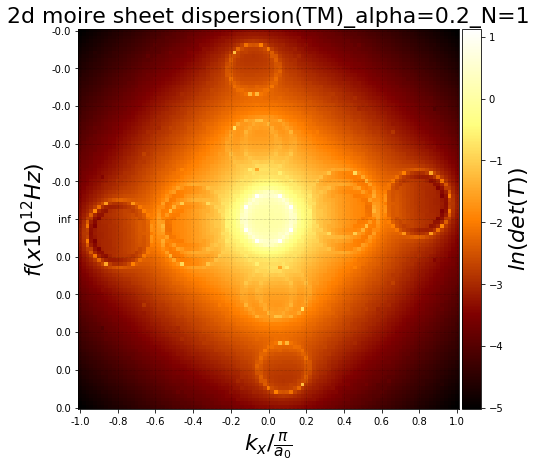

477.484375


In [113]:
alpha=0.2
N=1          ## dont put more than 1
N_kx=101
N_ky=N_kx
kx_list=5*np.linspace(-1,1,N_kx)*np.pi/a0
ky_list=5*np.linspace(-1,1,N_ky)*np.pi/a0
lam=1e-5*1.5
start=time.process_time()
TT=S_moire_2d_dispersion(kx_list,ky_list,lam,N,eps1,eps2,alpha)
plot_spectrum(np.log(TT),ky_list,kx_list,'2d moire sheet dispersion(TM)_alpha='+str(np.round(alpha,2))+'_N='+str(N),save=False)
print(time.process_time()-start)

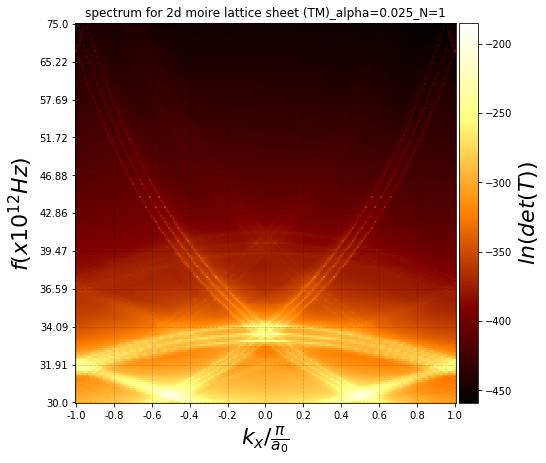

2342.34375


In [86]:
alpha=0.025
N=1          ## dont put more than 1
N_kx=201
N_lam=N_kx
kx_list=np.linspace(-1,1,N_kx)*np.pi/a0
lam_list=np.linspace(4,10,N_lam)*1e-6
start=time.process_time()
TT=S_moire_2d(lam_list,kx_list,N,eps1,eps2,alpha)
plot_spectrum(np.log(TT),lam_list,kx_list,'2d moire sheet (TM)_alpha='+str(alpha)+'_N='+str(N),save=True)
print(time.process_time()-start)

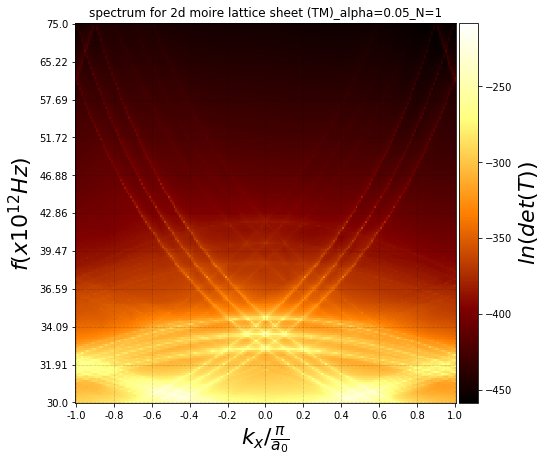

2354.4375


In [87]:
alpha=0.05
N=1          ## dont put more than 1
N_kx=201
N_lam=N_kx
kx_list=np.linspace(-1,1,N_kx)*np.pi/a0
lam_list=np.linspace(4,10,N_lam)*1e-6
start=time.process_time()
TT=S_moire_2d(lam_list,kx_list,N,eps1,eps2,alpha)
plot_spectrum(np.log(TT),lam_list,kx_list,'2d moire sheet (TM)_alpha='+str(alpha)+'_N='+str(N),save=True)
print(time.process_time()-start)

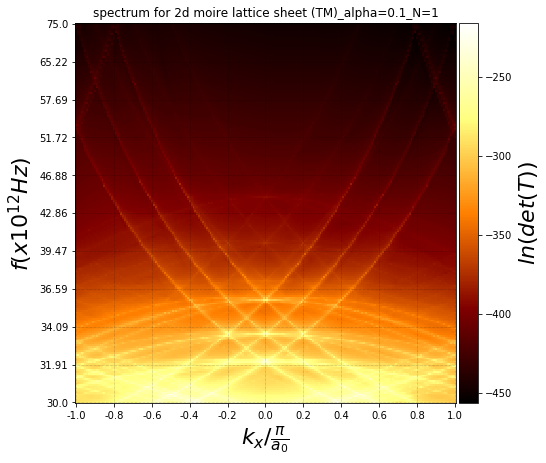

2401.25


In [49]:
alpha=0.1
N=1          ## dont put more than 1
N_kx=201
N_lam=N_kx
kx_list=np.linspace(-1,1,N_kx)*np.pi/a0
lam_list=np.linspace(4,10,N_lam)*1e-6
start=time.process_time()
TT=S_moire_2d(lam_list,kx_list,N,eps1,eps2,alpha)
plot_spectrum(np.log(TT),lam_list,kx_list,'2d moire sheet (TM)_alpha='+str(alpha)+'_N='+str(N),save=True)
print(time.process_time()-start)

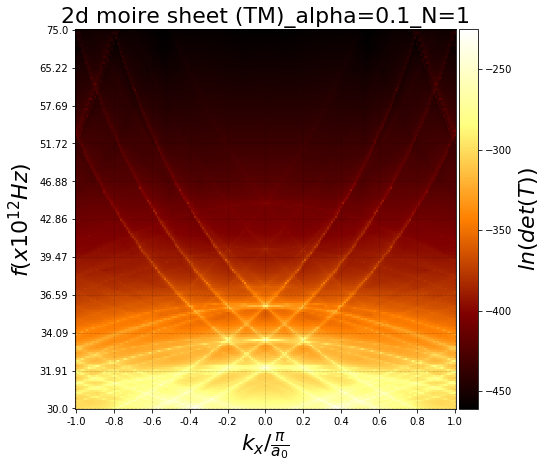

2010.03125


In [62]:
alpha=0.1
N=1          ## dont put more than 1
N_kx=201
N_lam=N_kx
kx_list=np.linspace(-1,1,N_kx)*np.pi/a0
lam_list=np.linspace(4,10,N_lam)*1e-6
start=time.process_time()
TT=S_moire_2d(lam_list,kx_list,N,eps1,eps2,alpha)
plot_spectrum(np.log(TT),lam_list,kx_list,'2d moire sheet (TM)_alpha='+str(alpha)+'_N='+str(N),save=True)
print(time.process_time()-start)

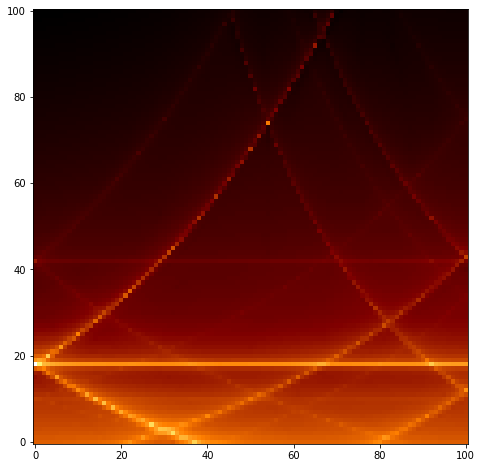

In [121]:
N=1  
N_alpha=101
N_lam=N_alpha
alpha_list=np.linspace(0,1,N_alpha)*np.pi/4
lam_list=np.linspace(4,10,N_lam)*1e-6

gamma=1
delta=0.5
a1=gamma*a0
d=1e-1*a0
h=0

gg=reciprocal_lattice(N,np.pi/2).reshape(1,M,2)
gg=(gg-np.transpose(gg,(1,0,2)))

sig_a=np.eye(M)*sig1+(sig2-sig1)*(np.pi*fd**2/2)*JJ((w/2)*np.sum(gg**2,axis=2)**0.5)
sig_a=np.kron(np.eye(M),sig_a)
sig_b=np.eye(M)*sig1+(sig2-sig1)*(np.pi*fd**2/2)*JJ((w/2)*np.sum(gg**2,axis=2)**0.5)*np.exp(1j*gg*(2*delta-1)*w/4)
sig_b=np.kron(sig_b,np.eye(M))
#print(np.shape(sig_a))
kxy0=np.array([0,0]).reshape(2,1)
TT=np.zeros((len(lam_list),len(alpha_list)))
for i_alpha,alpha in enumerate(alpha_list):
    d_b=(2*np.pi/a0)*np.array([np.cos(alpha),np.sin(alpha)]).reshape(2,1)
    g_list=moire_reciprocal(N,np.pi/2,alpha)
    #print(np.shape(g_list))
    abs_kxy=np.sum((kxy0+g_list)**2,axis=0)
    for i_lam,lam in enumerate(lam_list):
        k0=2*np.pi/lam
#             Slab_a=S_moire(eps2,eps3,abs_kxy,sig_a,k0)@S_translate(eps2,abs_kxy,d,k0)@S_moire(eps1,eps2,abs_kxy,sig_a,k0)
#             Slab_b=S_moire(eps4,eps5,abs_kxy,sig_b,k0)@S_translate(eps4,abs_kxy,d,k0)@S_moire(eps3,eps4,abs_kxy,sig_b,k0)
#             S=Slab_b@S_translate(eps3,abs_kxy,h,k0)@Slab_a
        S=S_moire(eps2,eps1,abs_kxy,sig_b,k0)@S_translate(eps2,abs_kxy,d,k0)@S_moire(eps1,eps2,abs_kxy,sig_a,k0)
        TT[i_lam][i_alpha]=(np.abs(np.linalg.det(ret_fresnel_coeff(S))))
plt.figure(figsize=(8,8))
plt.imshow(np.log(TT),cmap='afmhot',origin='lower')
plt.show()

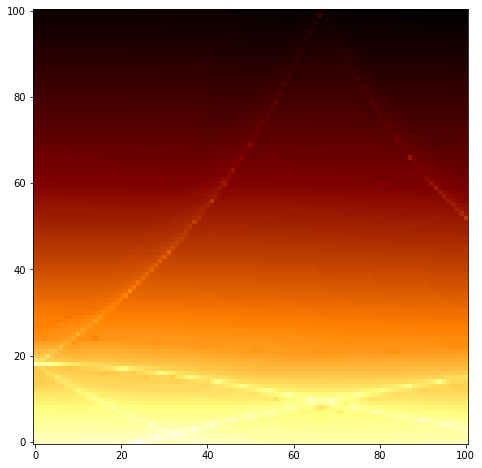

In [75]:
N=np.array([4,0])
M=(2*N+1)**2
N_theta=101
N_lam=N_theta
theta_list=np.linspace(0,1,N_theta)*np.pi/4

lam_list=np.linspace(4,10,N_lam)*1e-6
k0_list=2*np.pi/lam_list
gamma=1
delta=[0,0]
a1=gamma*a0
d=1e-1*a0
h=0

gga=reciprocal_lattice(N[0],np.pi/2).reshape(1,M[0],2)
gga=(gga-np.transpose(gga,(1,0,2)))
ggb=reciprocal_lattice(N[1],np.pi/2).reshape(1,M[1],2)
ggb=(ggb-np.transpose(ggb,(1,0,2)))

sig_a=np.eye(M[0])*sig1+(sig2-sig1)*(np.pi*fd**2/2)*JJ((w/2)*np.sum(gga**2,axis=2)**0.5)
sig_a=np.kron(np.eye(M[1]),sig_a)
sig_b=np.eye(M[1])*sig1+(sig2-sig1)*(np.pi*fd**2/2)*JJ((w/2)*np.sum(ggb**2,axis=2)**0.5)*np.exp(1j*np.dot(ggb,delta)*a0)
sig_b=np.kron(sig_b,np.eye(M[0]))
g_list=moire_reciprocal(N,np.pi/2,0).T

TT=np.zeros((len(lam_list),len(theta_list)))
for i_theta,theta in enumerate(theta_list):
    kx=(2*np.pi/a0)*np.sin(theta)
    kxy0=np.array([kx,0]).reshape(2,1)
    abs_kxy=np.sum((kxy0+g_list)**2,axis=0)
    for i_lam,lam in enumerate(lam_list):
        k0=2*np.pi/lam
        S=Scatter_Mat(abs_kxy,k0,eps2,eps1,sig_b)@S_translation(abs_kxy,k0,d,eps2)@Scatter_Mat(abs_kxy,k0,eps1,eps2,sig_a)
        TT[i_lam][i_theta]=(np.abs(np.linalg.det(ret_fresnel_coeff(S))))

plt.figure(figsize=(8,8))
plt.imshow(np.log(TT),cmap='afmhot',origin='lower')
plt.show()

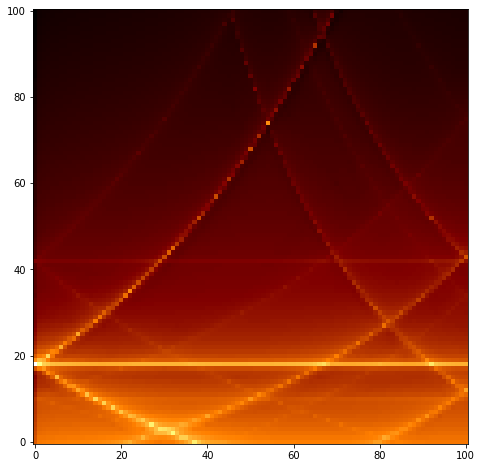

In [71]:
N=np.array([1,1])
M=(2*N+1)**2
N_alpha=101
N_lam=N_alpha
alpha_list=np.linspace(0,1,N_alpha)*np.pi/4
lam_list=np.linspace(4,10,N_lam)*1e-6
k0_list=2*np.pi/lam_list
gamma=1
delta=[0,0]
a1=gamma*a0
d=1e-1*a0
h=0

gga=reciprocal_lattice(N[0],np.pi/2).reshape(1,M[0],2)
gga=(gga-np.transpose(gga,(1,0,2)))
ggb=reciprocal_lattice(N[1],np.pi/2).reshape(1,M[1],2)
ggb=(ggb-np.transpose(ggb,(1,0,2)))

sig_a=np.eye(M[0])*sig1+(sig2-sig1)*(np.pi*fd**2/2)*JJ((w/2)*np.sum(gga**2,axis=2)**0.5)
sig_a=np.kron(np.eye(M[1]),sig_a)
sig_b=np.eye(M[1])*sig1+(sig2-sig1)*(np.pi*fd**2/2)*JJ((w/2)*np.sum(ggb**2,axis=2)**0.5)*np.exp(1j*np.dot(ggb,delta)*a0)
sig_b=np.kron(sig_b,np.eye(M[0]))

kxy0=np.array([0,0]).reshape(1,2)
TT=np.zeros((len(lam_list),len(alpha_list)))
for i_alpha,alpha in enumerate(alpha_list):
    d_b=(2*np.pi/a0)*np.array([np.cos(alpha),np.sin(alpha)]).reshape(2,1)
    g_list=moire_reciprocal(N,np.pi/2,alpha)
    abs_kxy=np.sum((kxy0+g_list)**2,axis=1)
    for i_k0,k0 in enumerate(k0_list):
#         Slab_a=S_moire(eps2,eps3,abs_kxy,sig_a,k0)@S_translate(eps2,abs_kxy,d,k0)@S_moire(eps1,eps2,abs_kxy,sig_a,k0)
#         Slab_b=S_moire(eps4,eps5,abs_kxy,sig_b,k0)@S_translate(eps4,abs_kxy,d,k0)@S_moire(eps3,eps4,abs_kxy,sig_b,k0)
#         S=Slab_b@S_translate(eps3,abs_kxy,h,k0)@Slab_a
        S=Scatter_Mat(abs_kxy,k0,eps2,eps1,sig_b)@S_translation(abs_kxy,k0,d,eps2)@Scatter_Mat(abs_kxy,k0,eps1,eps2,sig_a)
        TT[i_k0][i_alpha]=(np.abs(np.linalg.det(ret_fresnel_coeff(S))))
plt.figure(figsize=(8,8))
plt.imshow(np.log(TT),cmap='afmhot',origin='lower')
plt.show()


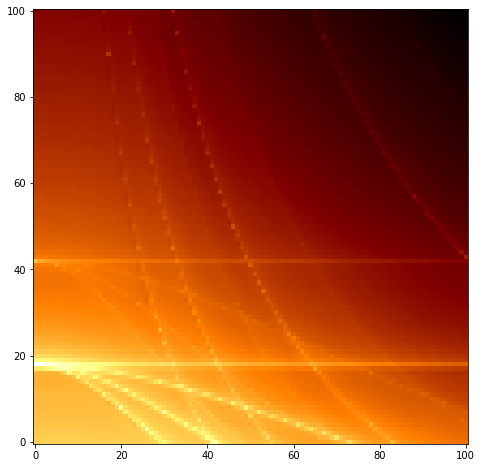

In [32]:
Na=4
Nb=4
Ma=(2*Na+1)**1
Mb=(2*Nb+1)**1

N_alpha=101
N_lam=N_alpha
alpha_list=np.linspace(0,1,N_alpha)*np.pi/4
lam_list=np.linspace(4,10,N_lam)*1e-6


gamma=1
delta=0
a1=gamma*a0
d=1e-1*a0
h=0
d_a=(2*np.pi/a0)*np.array([1,0]).reshape(2,1)
n_ab,n_ba=np.meshgrid(np.arange(-Na,Na+1),np.arange(-Nb,Nb+1))
n_ab=n_ab.flatten()
n_ba=n_ba.flatten()

gga=np.arange(-Na,Na+1).reshape(1,Ma)
gga=(2*np.pi/a0)*(gga-gga.T)
ggb=np.arange(-Nb,Nb+1).reshape(1,Mb)
ggb=(2*np.pi/a0)*(ggb-ggb.T)

sig_a=np.eye(2*Na+1)*sig1+(sig2-sig1)*(w/a0)*np.sinc((w/(2*np.pi))*gga)
sig_a=np.kron(np.eye(Mb),sig_a)
sig_b=np.eye(2*Nb+1)*sig1+(sig2-sig1)*(w/a0)*np.sinc((w/(2*np.pi))*ggb)*np.exp(1j*ggb*delta*a0)
sig_b=np.kron(sig_b,np.eye(Ma))
kxy0=np.array([0,0]).reshape(2,1)
TT=np.zeros((len(lam_list),len(alpha_list)))

for i_alpha,alpha in enumerate(alpha_list):
    d_b=(2*np.pi/a0)*np.array([np.cos(alpha),np.sin(alpha)]).reshape(1,2)
    g_list=n_ab*d_a+n_ba*d_b                      
    abs_kxy=np.sum((kxy0+g_list)**2,axis=1)
    for i_lam,lam in enumerate(lam_list):
        k0=2*np.pi/lam
#             Slab_a=S_moire(eps2,eps3,abs_kxy,sig_a,k0)@S_translate(eps2,abs_kxy,d,k0)@S_moire(eps1,eps2,abs_kxy,sig_a,k0)
#             Slab_b=S_moire(eps4,eps5,abs_kxy,sig_b,k0)@S_translate(eps4,abs_kxy,d,k0)@S_moire(eps3,eps4,abs_kxy,sig_b,k0)
#             S=Slab_b@S_translate(eps3,abs_kxy,h,k0)@Slab_a
        S=S_moire(eps2,eps1,abs_kxy,sig_b,k0)@S_translate(eps2,abs_kxy,d,k0)@S_moire(eps1,eps2,abs_kxy,sig_a,k0)
        TT[i_lam][i_alpha]=(np.abs(np.linalg.det(ret_fresnel_coeff(S))))
plt.figure(figsize=(8,8))
plt.imshow(np.log(TT),cmap='afmhot',origin='lower')
plt.show()

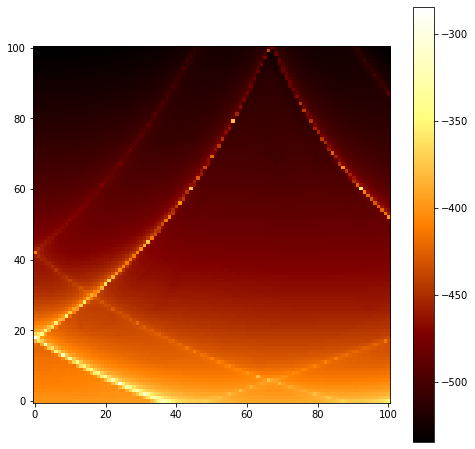

In [88]:
Na=4
Nb=4
Ma=(2*Na+1)**1
Mb=(2*Nb+1)**1

N_theta=101
N_lam=N_theta
theta_list=np.linspace(0,1,N_theta)*np.pi/4
lam_list=np.linspace(4,10,N_lam)*1e-6

d=1e-1*a0
d1=(2*np.pi/a0)*np.array([1,0]).reshape(2,1)
n_ab,n_ba=np.meshgrid(np.arange(-Na,Na+1),np.arange(-Nb,Nb+1))
n_ab=n_ab.flatten()
n_ba=n_ba.flatten()
g_list=n_ab*d1+n_ba*d1

gga=np.arange(-Na,Na+1).reshape(1,Ma)
gga=(2*np.pi/a0)*(gga-gga.T)
ggb=np.arange(-Nb,Nb+1).reshape(1,Mb)
ggb=(2*np.pi/a0)*(ggb-ggb.T)

sig_a=np.eye(2*Na+1)*sig1+(sig2-sig1)*(w/a0)*np.sinc((w/(2*np.pi))*gga)
sig_a=np.kron(np.eye(Mb),sig_a)
sig_b=np.eye(2*Nb+1)*sig1+(sig2-sig1)*(w/a0)*np.sinc((w/(2*np.pi))*ggb)
sig_b=np.kron(sig_b,np.eye(Ma))

TT=np.zeros((len(lam_list),len(alpha_list)))


for i_theta,theta in enumerate(theta_list):
    kx=(2*np.pi/a0)*np.sin(theta)
    kxy0=np.array([kx,0]).reshape(2,1)
    abs_kxy=np.sum((kxy0+g_list)**2,axis=0)
    for i_lam,lam in enumerate(lam_list):
        k0=2*np.pi/lam
        S=S_moire(eps2,eps1,abs_kxy,sig_b,k0)@S_translate(eps2,abs_kxy,d,k0)@S_moire(eps1,eps2,abs_kxy,sig_a,k0)
        TT[i_lam][i_theta]=(np.abs(np.linalg.det(ret_fresnel_coeff(S))))
        
plt.figure(figsize=(8,8))
plt.imshow(np.log(TT),cmap='afmhot',origin='lower')
plt.colorbar()
plt.show()

1

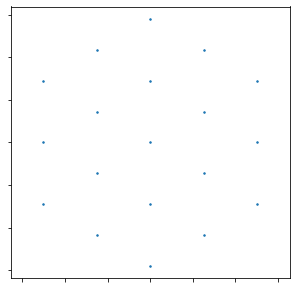

In [173]:
d_a=(2/3**0.5)*(2*np.pi/a0)*np.array([np.cos(-np.pi/6),np.sin(-np.pi/6)]).reshape(2,1)
d_b=(2/3**0.5)*(2*np.pi/a0)*np.array([np.cos(np.pi/6),np.sin(np.pi/6)]).reshape(2,1)
n_list=np.arange(-N,N+1)
nx=[]
ny=[]
for n_i in n_list:
    for n_j in n_list:
        if np.abs(n_i+n_j)<=N:
            nx.append(n_i)
            ny.append(n_j)
n_ab=np.array(nx)       
n_ba=np.array(ny)  
g_list=n_ab*d_a+n_ba*d_b

plt.figure(figsize=(5,5))
plt.plot(g_list[0,:],g_list[1,:],'.',markersize=3)
plt.tick_params(labelbottom=False,labelleft=False)
plt.axis('equal')
#plt.savefig('plots\moire_2d_alpha='+str(np.round(alpha,3))+'.jpg')
plt.show()

In [15]:
K=3
a=np.arange(2*K**2).reshape(K,K,2)
b=[0.1,0.2]
c=np.dot(a,b)
print(a)
print(b)
print(c)

[[[ 0  1]
  [ 2  3]
  [ 4  5]]

 [[ 6  7]
  [ 8  9]
  [10 11]]

 [[12 13]
  [14 15]
  [16 17]]]
[0.1, 0.2]
[[0.2 0.8 1.4]
 [2.  2.6 3.2]
 [3.8 4.4 5. ]]


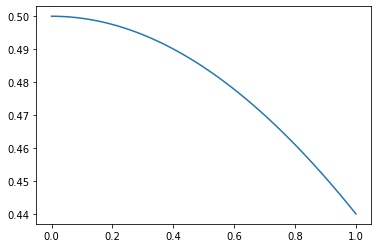

In [6]:
x=np.linspace(0,1,100)
plt.plot(x,JJ(x))